---
embed-resources: true
---

In [22]:
import numpy as np
import torch
import torch.nn.functional as F

First signalling game. Simple, states and messages are integers.

The scenario is that of a two players signalling game with an environment (The Nature) that selects a state. Given the state, Alice chooses a message and when Bob receives it he selects an action. In case Bob performs the action that matches the state chosen by nature, the cooperation game is a success otherwise it is a failure.

The game is characterized by:

 - the number of states $S$ available to Nature;
 - the number of messages $M$ available to Alice;
 - the number of actions $A$ available to Bob.

States, messages and actions are represented by vectors of positive or null weights that are to be normalized before sampling. Since the weights are positive, one can normalize them straightforwardly: $$w_i = \frac{w_i}{\sum_{j=1}^k w_j}$$ for a vector $\mathbf{w}$ with length $k$.

In [2]:
class SignallingGame:

    def __init__(self, states: int, messages: int, actions: int, seed: int = 42):
        self.states = states
        self.messages = messages
        self.actions = actions
        self.message_weights = np.full((states, messages), 1e-6, dtype=float)
        self.action_weights = np.full((messages, actions), 1e-6, dtype=float)
        self.rng = np.random.RandomState(seed)
        self.stats = []


    def world_state(self):
        return self.rng.randint(self.states)


    def emit_message(self, state):
        w = self.message_weights[state, :]
        probs = w / np.sum(w)
        message = self.rng.choice(self.messages, p=probs)
        return message


    def perform_action(self, message):
        w = self.action_weights[message, :]
        probs = w / np.sum(w)
        action = self.rng.choice(self.actions, p=probs)
        return action


    def payoff(self, state, action):
        return 1 if action == state else 0


    def update_weights(self, state, message, action, payoff):
        self.message_weights[state, message] += payoff
        self.action_weights[message, action] += payoff


    def export_weights(self):
        return self.message_weights.copy(), self.action_weights.copy()


    def snapshot(self, state, message, action, payoff):
        mw, aw = self.export_weights()
        self.stats.append({
            "s": state,
            "m": message,
            "a": action,
            "p": payoff,
            "mw": mw,
            "aw": aw,
        })


    def play(self, N: int):
        for _ in range(N):
            state = self.world_state()
            message = self.emit_message(state)
            action = self.perform_action(message)
            payoff = self.payoff(state, action)
            self.update_weights(state, message, action, payoff)
            self.snapshot(state, message, action, payoff)

In [17]:
game1 = SignallingGame(states=3, messages=3, actions=3)
game1.play(1000)

# Payoffs over time
payoffs = [x["p"] for x in game1.stats]
print("Number of rounds:", len(payoffs))
print("First 20 payoffs:", payoffs[:50])
print("Last 20 payoffs:", payoffs[-50:])
print(f"Success rate: {sum(payoffs)/len(payoffs)*100:.2f}%")

Number of rounds: 1000
First 20 payoffs: [0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0]
Last 20 payoffs: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Success rate: 98.20%


Then I simply add the Roth-Erev update algorithm.

Implement a simulation method that plays the game $N$ times and updates the player related vectors using the Roth-Erev update. For a single game the update is the following:

- $w_i = \lambda w_i + u$ if $i$ was chosen;
- $w_i = \lambda w_i$ if $i$ was not chosen;
- $w_i = \lambda w_i$ if $i$ was not sampled in this game;

where $u$ is the payoff and $\lambda \in [0,1]$.

In [18]:
class RothErevGame(SignallingGame):
    def __init__(self, states: int, messages: int, actions: int, l: float, seed: int = 42):
        super().__init__(states, messages, actions, seed)
        self.l = l

    def update_weights(self, state, message, action, payoff):
        self.message_weights[state] *= self.l
        self.message_weights[(state, message)] += payoff
        self.action_weights[message] *= self.l
        self.action_weights[(message, action)] += payoff

In [27]:
game2 = RothErevGame(states=3, messages=3, actions=3, l=0.5)
game2.play(1000)

# Payoffs over time
payoffs = [x["p"] for x in game2.stats]
print("Number of rounds:", len(payoffs))
print("First 20 payoffs:", payoffs[:50])
print("Last 20 payoffs:", payoffs[-50:])
print(f"Success rate: {sum(payoffs)/len(payoffs)*100:.2f}%")

Number of rounds: 1000
First 20 payoffs: [0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0]
Last 20 payoffs: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Success rate: 98.20%


Simple update to the original signalling game: just add a minimal version of the reinforce algorithm.

In [31]:
class ReinforcedGame(SignallingGame):
    def __init__(self, states, messages, actions, lr, seed=42):
        super().__init__(states, messages, actions, seed)

        self.message_weights = torch.nn.Parameter(torch.zeros(states, messages))
        self.action_weights = torch.nn.Parameter(torch.zeros(messages, actions))
        self.optimizer = torch.optim.SGD([self.message_weights, self.action_weights], lr=lr)


    def emit_message(self, state):
        with torch.no_grad():
            probs = torch.softmax(self.message_weights[state], dim=-1)
            message = self.rng.choice(self.messages, p=probs.cpu().numpy())
        return message


    def perform_action(self, message):
        with torch.no_grad():
            probs = torch.softmax(self.action_weights[message], dim=-1)
            action = self.rng.choice(self.actions, p=probs.cpu().numpy())
        return action


    def update_weights(self, state, message, action, payoff):
        reward = torch.tensor(float(payoff))

        # Alice
        log_probs_m = torch.log_softmax(self.message_weights[state], dim=-1)[message]
        loss_m = -reward * log_probs_m

        # Bob
        log_probs_a = torch.log_softmax(self.action_weights[message], dim=-1)[action]
        loss_a = -reward * log_probs_a

        loss = loss_m + loss_a
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


    def export_weights(self):
        return (
            self.message_weights.detach().cpu().numpy().copy(),
            self.action_weights.detach().cpu().numpy().copy(),
        )

In [46]:
game3 = ReinforcedGame(states=3, messages=3, actions=3, lr=0.5)
game3.play(1000)

# Payoffs over time
payoffs = [x["p"] for x in game3.stats]
print("Number of rounds:", len(payoffs))
print("First 20 payoffs:", payoffs[:50])
print("Last 20 payoffs:", payoffs[-50:])
print(f"Success rate: {sum(payoffs)/len(payoffs)*100:.2f}%")

Number of rounds: 1000
First 20 payoffs: [0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0]
Last 20 payoffs: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Success rate: 92.00%


Now to implement the reinforce algorithm in the weights update.

In [47]:
class ReinforcedGameBatch(ReinforcedGame):
    def __init__(self, states, messages, actions, lr, batch_size, seed=42):
        super().__init__(states, messages, actions, lr, seed)
        self.batch_size = batch_size


    def run_batch(self, batch_n: int):
        self.optimizer.zero_grad()
        batch_loss = torch.tensor(0.0)

        for _ in range(batch_n):
            state = self.world_state()
            message = self.emit_message(state)
            action = self.perform_action(message)
            payoff = self.payoff(state, action)

            r = torch.tensor(float(payoff))
            log_probs_m = torch.log_softmax(self.message_weights[state], dim=-1)[message]
            log_probs_a = torch.log_softmax(self.action_weights[message], dim=-1)[action]
            batch_loss += -r * (log_probs_m + log_probs_a)
            self.snapshot(state, message, action, payoff)

        (batch_loss / batch_n).backward()
        self.optimizer.step()


    def play(self, N: int):
        num_batches = N // self.batch_size
        remainder = N % self.batch_size

        for _ in range(num_batches):
            self.run_batch(self.batch_size)

        if remainder > 0:
            self.run_batch(remainder)

In [48]:
game3 = ReinforcedGameBatch(states=3, messages=3, actions=3, lr=1, batch_size=1)
game3.play(1000)

# Payoffs over time
payoffs = [x["p"] for x in game3.stats]
print("Number of rounds:", len(payoffs))
print("First 20 payoffs:", payoffs[:50])
print("Last 20 payoffs:", payoffs[-50:])
print("Total reward:", sum(payoffs))

Number of rounds: 1000
First 20 payoffs: [0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0]
Last 20 payoffs: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Total reward: 950


Now that it works with simple integers, we can try with tuples.

The game context is that of Referential games where Nature shows $K$ pictures to Alice and chooses one of them. Then Alice has to send a message to Bob telling which picture she has seen in the list. Bob sees the list of pictures in the same order and has to guess which one Nature had chosen.

In our case the pictures will be digits from 0 to 9 coloured in red, green, blue or white and of different sizes: small, medium and large. (You are free to add different properties if you like).

We consider that each picture is represented by a tuple $(D,C,S)$ where $D$ is the digit value, $C$ the color and $S$ the size of the digit.

The symbolic game is made of 2 agents (Alice and Bob) and one environment (Nature). Nature shows $K$ pictures to Alice and selects one. Alice sends a message to Bob and this is a single symbol taken from a finite set $M$ of messages in this baseline. By design you may wish to structure the symbol as a tuple of 3 features to ease interpretation.

In [ ]:
class ReferentialReinforcedGame:
    """
    A two-agent referential signalling game trained with REINFORCE.

    Alice (Sender) observes the target picture and emits a discrete message.
    Bob (Receiver) observes the message and all pictures and selects a picture.
    Both agents are rewarded if Bob selects the correct target.
    """

    def __init__(
        self,
        K: int,
        img_sizes=(10, 4, 3),
        lr: float = 0.1,
        batch_size: int = 20,
        n_digits: int = 10,
        n_colors: int = 4,
        n_sizes: int = 3,
        emb_dim: int = 3,
        seed: int = 42,
    ):

        """
        Initialize the game, agents, and learning machinery.
        - Fix the structure of the world (number of pictures, feature vocabularies).
        - Define Alice's and Bob's internal representations and policies.
        - Prepare an optimizer to train both agents jointly via reinforcement learning.
        """
        self.K = K
        self.img_sizes = img_sizes
        self.batch_size = batch_size
        self.rng = np.random.RandomState(seed)
        self.stats = []

        self.n_digits = img_sizes[0]
        self.n_colors = img_sizes[1]
        self.n_sizes = img_sizes[2]

        # --- Alice: policy π_A(m | target(D,C,S)) as 3 categorical heads
        # Use embeddings for target features, then linear heads to logits.

        # Embeddings for target picture features
        self.d_emb = torch.nn.Embedding(img_sizes[0], emb_dim)
        self.c_emb = torch.nn.Embedding(img_sizes[1], emb_dim)
        self.s_emb = torch.nn.Embedding(img_sizes[2], emb_dim)

        # Message heads: categorical distributions over symbols
        self.head_mD = torch.nn.Linear(emb_dim, img_sizes[0])
        self.head_mC = torch.nn.Linear(emb_dim, img_sizes[1])
        self.head_mS = torch.nn.Linear(emb_dim, img_sizes[2])

        # --- Bob: policy π_B(i | m, pictures) over i in {0..K-1}
        # Embeddings for received message symbols
        self.mD_emb = torch.nn.Embedding(img_sizes[0], emb_dim)
        self.mC_emb = torch.nn.Embedding(img_sizes[1], emb_dim)
        self.mS_emb = torch.nn.Embedding(img_sizes[2], emb_dim)

        # Optimizer
        self.optimizer = torch.optim.SGD(self.parameters(), lr=lr)


    def parameters(self):
        return list(self.d_emb.parameters()) + list(self.c_emb.parameters()) + list(self.s_emb.parameters()) + \
               list(self.head_mD.parameters()) + list(self.head_mC.parameters()) + list(self.head_mS.parameters()) + \
               list(self.mD_emb.parameters()) + list(self.mC_emb.parameters()) + list(self.mS_emb.parameters())


    # Nature
    def world_state(self):
        """
        Sample a world state.
        - Nature generates K pictures, each with latent features (D, C, S).
        - Nature privately selects one picture as the communicative target.
        """
        pictures = []
        for _ in range(self.K):
            D = self.rng.randint(self.n_digits)
            C = self.rng.randint(self.n_colors)
            S = self.rng.randint(self.n_sizes)
            pictures.append((D, C, S))
        target = self.rng.randint(self.K)
        return pictures, target


    # Alice
    def _target_repr(self, Dt, Ct, St):
        """
        Build Alice's internal representation of the target picture.
        - Alice embeds each feature of the target picture.
        - The summed embedding represents Alice's private perception.
        """
        Dt = torch.tensor(Dt, dtype=torch.long)
        Ct = torch.tensor(Ct, dtype=torch.long)
        St = torch.tensor(St, dtype=torch.long)
        return self.d_emb(Dt) + self.c_emb(Ct) + self.s_emb(St)


    def emit_message(self, pictures, target):
        """
        Alice emits a discrete message describing the target picture.
        - Alice observes only the target picture.
        - She samples a multi-symbol message from her stochastic policy π_A.
        - The message is her attempt to guide Bob to the target.
        """
        Dt, Ct, St = pictures[target]

        with torch.no_grad():
            h = self._target_repr(Dt, Ct, St)
            logits_D = self.head_mD(h)
            logits_C = self.head_mC(h)
            logits_S = self.head_mS(h)

            pD = torch.softmax(logits_D, dim=-1).cpu().numpy()
            pC = torch.softmax(logits_C, dim=-1).cpu().numpy()
            pS = torch.softmax(logits_S, dim=-1).cpu().numpy()

        mD = self.rng.choice(self.img_sizes[0], p=pD)
        mC = self.rng.choice(self.img_sizes[1], p=pC)
        mS = self.rng.choice(self.img_sizes[2], p=pS)

        message = (mD, mC, mS)
        return message


    # Bob
    def _message_repr(self, m):
        """
        Build Bob's internal representation of the received message.
        - Bob embeds each symbol of Alice's message.
        - The combined embedding represents Bob's interpretation.
        """
        mD, mC, mS = m
        mD = torch.tensor(mD, dtype=torch.long)
        mC = torch.tensor(mC, dtype=torch.long)
        mS = torch.tensor(mS, dtype=torch.long)
        return self.mD_emb(mD) + self.mC_emb(mC) + self.mS_emb(mS)


    def _picture_repr(self, pic):
        """
        Build Bob's internal representation of a picture.
        - Bob embeds each candidate picture.
        """
        D, C, S = pic
        D = torch.tensor(D, dtype=torch.long)
        C = torch.tensor(C, dtype=torch.long)
        S = torch.tensor(S, dtype=torch.long)
        return self.d_emb(D) + self.c_emb(C) + self.s_emb(S)


    def perform_action(self, pictures, message):
        """
        Bob selects a picture based on the received message.
        - Bob scores each picture by similarity with the message.
        - He samples a picture index from his policy π_B.
        """
        with torch.no_grad():
            message_vec = self._message_repr(message)
            scores = []
            for pic in pictures:
                pic_vec = self._picture_repr(pic)
                scores.append(torch.dot(pic_vec, message_vec))
            scores = torch.stack(scores) # (K,)
            probs = torch.softmax(scores, dim=-1).cpu().numpy()
        return self.rng.choice(self.K, p=probs)


    def payoff(self, target, action):
        """Compute the shared reward."""
        return 1 if action == target else 0


    # Reinforce over batches
    def run_batch(self, batch_n: int):
        """Run a batch of episodes and update both agents via REINFORCE."""
        self.optimizer.zero_grad()
        batch_loss = torch.zeros(())

        for _ in range(batch_n):
            pictures, target = self.world_state()
            message = self.emit_message(pictures, target)
            action = self.perform_action(pictures, message)
            r = float(self.payoff(target, action))
            reward = torch.tensor(r, dtype=torch.float32)

            # log π_A(m | target)
            Dt, Ct, St = pictures[target]
            h = self._target_repr(Dt, Ct, St)
            log_probs_mD = F.log_softmax(self.head_mD(h), dim=-1)[message[0]]
            log_probs_mC = F.log_softmax(self.head_mC(h), dim=-1)[message[1]]
            log_probs_mS = F.log_softmax(self.head_mS(h), dim=-1)[message[2]]
            log_probs_A = log_probs_mD + log_probs_mC + log_probs_mS

            # log π_B(a | m, pictures)
            message_vec = self._message_repr(message)
            scores = []
            for pic in pictures:
                pic_vec = self._picture_repr(pic)
                scores.append(torch.dot(pic_vec, message_vec))
            scores = torch.stack(scores)
            log_probs_B = F.log_softmax(scores, dim=-1)[action]

            # Reinforce loss: -r * (log π_A + log π_B)
            batch_loss = batch_loss + (-reward * (log_probs_A + log_probs_B))

            self.stats.append({"pics": pictures, "t": target, "m": message, "a": action, "p": int(r)})

        (batch_loss / batch_n).backward()
        self.optimizer.step()


    def play(self, N: int):
        """Run N episodes of the signalling game."""
        num_batches = N // self.batch_size
        rem = N % self.batch_size

        for _ in range(num_batches):
            self.run_batch(self.batch_size)
        
        if rem > 0:
            self.run_batch(rem)

In [68]:
game4 = ReferentialReinforcedGame(K=5, lr=0.5, batch_size=20)
game4.play(20000)

payoffs = [x["p"] for x in game4.stats]
print("Number of rounds:", len(payoffs))
print("First 50 payoffs:", payoffs[:50])
print("Last 50 payoffs:", payoffs[-50:])
print(f"Success rate: {sum(payoffs)/len(payoffs)*100:.2f}%")

Number of rounds: 20000
First 50 payoffs: [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0]
Last 50 payoffs: [1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1]
Success rate: 66.88%


Try the signalling game with real images!

First example: (<PIL.Image.Image image mode=L size=28x28 at 0x157445C40>, 5), an object of <class 'tuple'>.


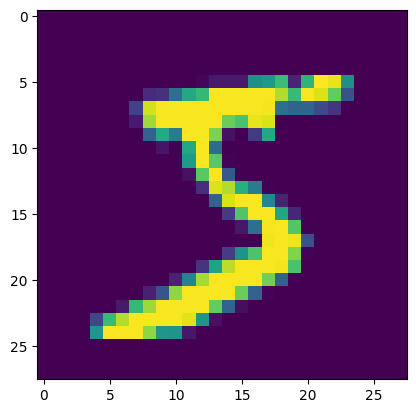

In [19]:
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST

dataset = MNIST("data", download=True)
print(f"First example: {dataset[0]}, an object of {type(dataset[0])}.")
plt.imshow(dataset[0][0])
plt.show()

Turn the image to a standard torch tensor.

In [20]:
from torchvision.transforms.functional import pil_to_tensor

img_tensor = pil_to_tensor(dataset[0][0])
print(img_tensor.shape)

torch.Size([1, 28, 28])


In [5]:
from torchvision.transforms import Pad, Resize


def scale_transform(image_tensor, scale_code):
    """
    Scale image by padding and resizing.
    scale_code: 0 for original size, 1 for small, 2 for very small
    """
    padded = Pad(10 * scale_code, fill=0)(image_tensor)
    scaled = Resize((28, 28))(padded)
    return scaled


def color_transform(image_tensor, color_code):
    """
    Convert grayscale image to coloured RGB image.
    color_code: Color channel - "red", "green", or "blue"
    """
    coloured = torch.zeros((3, 28, 28), dtype=torch.float32)
    
    color_channels = {
        "red": 0,
        "green": 1,
        "blue": 2
    }
    
    if color_code not in color_channels:
        raise ValueError(f"Invalid color code: {color_code}. Must be 'red', 'green', or 'blue'")
    
    coloured[color_channels[color_code]] = image_tensor
    return coloured


def color_scale(image_tensor, color_code="green", scale_code=0):
    """
    Apply color transformation followed by scaling.
    color_code: Color channel - "red", "green", or "blue" (default: "green")
    scale_code: 0 for original size, 1 for small, 2 for very small (default: 0)
    """
    return scale_transform(color_transform(image_tensor, color_code), scale_code)

Create a randomized dataset.

In [ ]:
import random
from torchvision.transforms import ToTensor

# Configuration
COLORS = ["red", "green", "blue"]
SIZES = [0, 1, 2]

def randomize_tensorize_img(img_label_pair):
    img = ToTensor()(img_label_pair[0])
    color = random.choice(COLORS)
    size = random.choice(SIZES)
    return color_scale(img, color_code=color, scale_code=size)

# Transform entire dataset: random colors and sizes
mnist_colors = torch.stack([randomize_tensorize_img(item) for item in dataset])

# Extract labels
gold_classes = [label for _, label in dataset]

In [28]:
mnist_colors[0]

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

Now to build an auto-encoder.

To get an image vector, we will use a primitive method for encoding the images. First we get a raw vector by flattening the image matrices (one matrix for each channel) and then these three vectors are concatenated.

Then we perform dimension reduction by using a simple auto-encoder. An auto-encoder is a neural network whose task it to predict its input. The key feature is that the auto-encoder maps the input to a low dimension vector and then maps this low dimension representation again to the input dimension. In its simplest form it takes the form of a feed-forward network trained with an MSE loss.

In [ ]:
import torch
import torch.nn as nn
from tqdm import tqdm
from torchvision.transforms.functional import pil_to_tensor


class MNISTAutoencoder(nn.Module):
    """
    Autoencoder for MNIST images with color channels.
    Encodes flattened RGB images (3*28*28 = 2352 dims) to a lower dimensional
    latent representation and reconstructs the original image.
    """


    def __init__(self, input_dim=2352, latent_dim=64):
        """
        input_dim: Flattened image dimension (default: 28*28*3 = 2352)
        latent_dim: Dimension of latent representation
        """
        super().__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim

        # Encoder: input_dim -> 128 -> latent_dim
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)
        )

        # Decoder: latent_dim -> 128 -> input_dim
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim),
            nn.Sigmoid()  # Output in [0, 1] range
        )


    def forward(self, x):
        z = self.encoder(x)
        x_reconstructed = self.decoder(z)
        return x_reconstructed


    def encode(self, image):
        """
        image: Tensor of shape (3, 28, 28) or batch (N, 3, 28, 28)
        Returns: latent representation tensor
        """
        # Handle single image or batch
        if image.dim() == 3:
            image = image.unsqueeze(0)  # Add batch dimension
        
        # Flatten to (batch_size, input_dim)
        flattened = image.reshape(-1, self.input_dim)
        
        with torch.no_grad():
            encoded = self.encoder(flattened)
        
        return encoded.squeeze(0) if encoded.size(0) == 1 else encoded


    def train_autoencoder(self, dataset, batch_size=64, epochs=10, lr=1e-3, device="cpu"):
        """
        dataset: Tensor of images, shape (N, 3, 28, 28)
        batch_size: Number of samples per batch
        epochs: Number of training epochs
        lr: Learning rate
        device: Device to train on ('cpu' or 'cuda')
        """
        self.to(device)
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        n_batches = len(dataset) // batch_size

        # Progress bar for batches
        progress_bar = tqdm(range(epochs), desc=f"Training over {epochs} epochs")

        for _ in progress_bar:
            self.train()  # Set to training mode
            total_loss = 0.0

            for batch_idx in range(n_batches):
                # Get batch and flatten
                start_idx = batch_idx * batch_size
                end_idx = start_idx + batch_size
                batch = dataset[start_idx:end_idx]
                x = batch.reshape(-1, self.input_dim).to(device)

                # Forward pass
                optimizer.zero_grad()
                x_reconstructed = self.forward(x)
                loss = criterion(x_reconstructed, x)

                # Backward pass
                loss.backward()
                optimizer.step()

                total_loss += loss.item() * x.size(0)

            # Print epoch statistics
            avg_loss = total_loss / (n_batches * batch_size)
            progress_bar.set_postfix({'loss': f'{avg_loss:.6f}'})


    def save_model(self, filename):
        torch.save(self.state_dict(), filename)


    def load_model(self, filename, device="cpu"):
        self.load_state_dict(torch.load(filename, map_location=device))
        self.eval()  # Set to evaluation mode

In [40]:
autoencoder = MNISTAutoencoder(input_dim=2352, latent_dim=64)
autoencoder.train_autoencoder(mnist_colors, batch_size=64, epochs=10)
latent = autoencoder.encode(mnist_colors[0])

Training over 10 epochs: 100%|██████████| 10/10 [00:12<00:00,  1.22s/it, loss=0.001374]


In [41]:
print(latent)

tensor([-3.5065, -2.1654,  0.8226, -3.2303, -1.2804, -0.3794,  2.8731, -2.7587,
         3.7483,  0.4544, -0.3329, -0.9329, -1.4259,  0.7484,  0.6871, -1.7490,
        -2.7567,  3.1037, -1.3060,  2.6482,  0.9673, -2.9948, -2.9975, -1.3254,
         5.4895,  2.2969,  0.2945,  0.6460, -0.9454, -1.7489, -3.3205,  2.4837,
         3.5516,  3.0818,  1.2375,  0.6716, -0.9372, -2.4742, -1.3209, -1.0042,
        -3.2583,  1.2475, -0.6093, -0.7634, -0.7961,  0.7088,  1.7656, -0.8446,
         1.5638,  1.4276,  5.7076, -4.2542,  4.5978,  1.1984, -3.2465, -1.6063,
         5.7736,  2.1653,  3.4059, -0.2373,  1.4847, -1.0380, -2.6935,  1.0564])
